<a href="https://colab.research.google.com/github/elenasofia98/PracticalNLP-2023-2024/blob/main/HoL06_1_XAI_PostHocBlackBox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction: Feature Attribution for Black Box Models
https://dl.acm.org/doi/10.1145/3546577


**Feature attribution methods**:

Feature saliency refers to the importance of input features in influencing the output of a neural model.

NB: Attention mechanisms (in principle) provide a model-internal way to extract similar information.

The patterns can be used to illuminate a particular decision made by a model; this has been called prediction interpretability.


Attribution methods produce **importance scores** (or *saliency scores*) for every element of the input, reflecting the importance of every input element in driving the model prediction. These scores are often presented using **highlights** (or *attribution maps*).


https://github.com/inseq-team/inseq/blob/main/examples/inseq_tutorial.ipynb
We can categorize feature attribution approaches in three major families:

- **Gradient-based methods** such as [Integrated gradients]() use gradients as a natural source of information to motivate model predictions. Gradients for model parameters computed in relation to a loss function are commonly used during training to update model parameters, since they represent *the magnitude of change needed for a parameter such that the prediction matches the target label*. In the case of feature attribution, gradients computed with respect to a model prediction logit or probability are instead taken as *how much the parameter is contributing towards the prediction*.

- **Perturbation-based methods** such as [LIME](https://aclanthology.org/N16-3020.pdf) estimate importance of inputs by introducing noise in the prediction process, usually by masking or removing either input features or network components, and verifying the downstream effect on model predictions. Intuitively, these can also be used to determine the importance of layers in the neural network.

- **Internals-based methods** use quantities computed naturally by the network during their predictions to motivate its internal computations. For Transformers-based model, [attention weights](https://aclanthology.org/D19-1002/) are commonly used, by themselves or multiplied with other quantities, as indications of feature importance. Examples of this are attention rollout and flow.


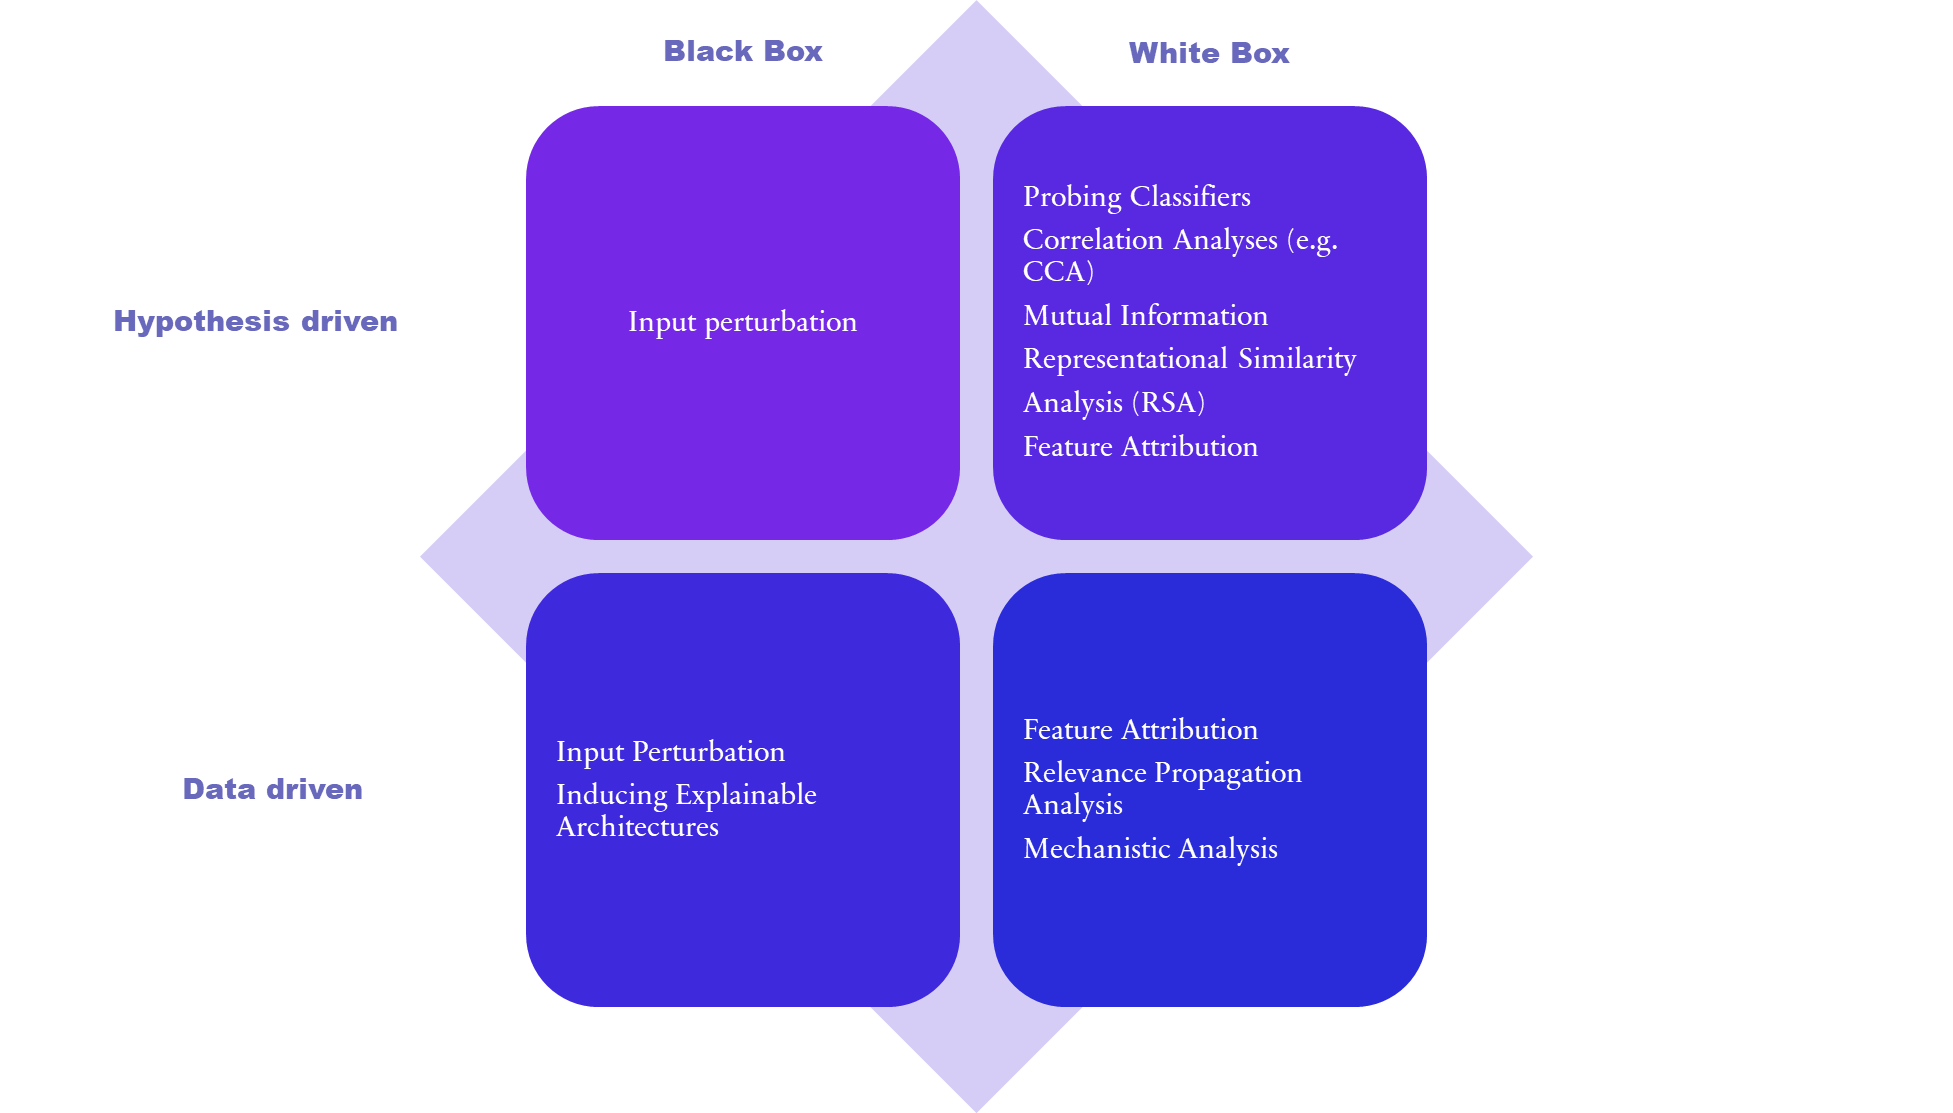

## Load dataset

In [1]:
from tokenizers import Tokenizer
from transformers import BertTokenizer
from transformers import BertConfig
from transformers import AutoTokenizer, BertForSequenceClassification
import torch


def load_tokenizer():
    tokenizer = BertTokenizer("data/tokenizer-wiki-vocab.txt") # trained in 00
    return tokenizer

In [2]:
!pip install datasets
from datasets import load_dataset

dataset = load_dataset("glue", "mrpc",  split={"train":'train[:40%]','validation':'validation[:50%]'})
dataset

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.4 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/3668 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/408 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1725 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 1467
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 204
    })
})

In [3]:
task_columns = {
    'mrpc': ['sentence1', 'sentence2'],
}

def concat_dataset(dataset, TASK):
    def concat(example):
        [col1, col2] = task_columns[TASK]
        example['sentence'] = example[col1] + " [SEP] " + example[col2]
        return example

    dataset = dataset.map(concat)
    return dataset

dataset = concat_dataset(dataset, 'mrpc')

Map:   0%|          | 0/1467 [00:00<?, ? examples/s]

Map:   0%|          | 0/204 [00:00<?, ? examples/s]

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx', 'sentence'],
        num_rows: 1467
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx', 'sentence'],
        num_rows: 204
    })
})

In [5]:
def tokenize_train(dataset, tokenizer, max_len=None):
    if max_len is None:
        # Print the original sentence.
        print(' Original: ', dataset['train']['sentence'][0])
        # Print the sentence split into tokens.
        print('Tokenized: ', tokenizer.tokenize(dataset['train']['sentence'][0]))
        # Print the sentence mapped to token ids.
        print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(dataset['train']['sentence'][0])))


        max_len = 0

        # For every sentence...
        for sent in dataset['train']['sentence']:
            # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
            input_ids = tokenizer.encode(sent, add_special_tokens=True)

            # Update the maximum sentence length.
            max_len = max(max_len, len(input_ids))

        print('Max sentence length: ', max_len)
        max_len = min(max_len, 128)
        print('Max sentence length after update: ', max_len)


    # Tokenize all of the sentences and map the tokens to thier word IDs.
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in dataset['train']['sentence']:
        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.encode_plus(
            sent,                      # Sentence to encode.
            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
            max_length = max_len,
            truncation=True, # Pad & truncate all sentences.
            pad_to_max_length = True,
            return_attention_mask = True,   # Construct attn. masks.
            return_tensors = 'pt',     # Return pytorch tensors.
        )

        # Add the encoded sentence to the list.
        input_ids.append(encoded_dict['input_ids'])

        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(dataset['train']['label'])

    # Print sentence 0, now as a list of IDs.
    print('Original: ', dataset['train']['sentence'][0])
    print('Token IDs:', input_ids[0])

    return input_ids, attention_masks, labels, max_len

In [6]:
from torch.utils.data import TensorDataset, random_split


def split(input_ids, attention_masks, labels):
    # Combine the training inputs into a TensorDataset.
    train_dataset = TensorDataset(input_ids, attention_masks, labels)

    # Create a 90-10 train-validation split.

    # Calculate the number of samples to include in each set.
    train_size = int(0.9 * len(train_dataset))
    val_size = len(train_dataset) - train_size

    # Divide the dataset by randomly selecting samples.
    train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size],
                                              generator=torch.Generator().manual_seed(42))

    print('{:>5,} training samples'.format(train_size))
    print('{:>5,} validation samples'.format(val_size))

    return train_dataset, val_dataset

In [7]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
input_ids, attention_masks, labels, max_len = tokenize_train(dataset, tokenizer)
train_dataset, val_dataset = split(input_ids, attention_masks, labels)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

 Original:  Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence . [SEP] Referring to him as only " the witness " , Amrozi accused his brother of deliberately distorting his evidence .
Tokenized:  ['am', '##ro', '##zi', 'accused', 'his', 'brother', ',', 'whom', 'he', 'called', '"', 'the', 'witness', '"', ',', 'of', 'deliberately', 'di', '##stor', '##ting', 'his', 'evidence', '.', '[SEP]', 'referring', 'to', 'him', 'as', 'only', '"', 'the', 'witness', '"', ',', 'am', '##ro', '##zi', 'accused', 'his', 'brother', 'of', 'deliberately', 'di', '##stor', '##ting', 'his', 'evidence', '.']
Token IDs:  [2572, 3217, 5831, 5496, 2010, 2567, 1010, 3183, 2002, 2170, 1000, 1996, 7409, 1000, 1010, 1997, 9969, 4487, 23809, 3436, 2010, 3350, 1012, 102, 7727, 2000, 2032, 2004, 2069, 1000, 1996, 7409, 1000, 1010, 2572, 3217, 5831, 5496, 2010, 2567, 1997, 9969, 4487, 23809, 3436, 2010, 3350, 1012]
Max sentence length:  103
Max sentence length after update:  

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2618: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence . [SEP] Referring to him as only " the witness " , Amrozi accused his brother of deliberately distorting his evidence .
Token IDs: tensor([  101,  2572,  3217,  5831,  5496,  2010,  2567,  1010,  3183,  2002,
         2170,  1000,  1996,  7409,  1000,  1010,  1997,  9969,  4487, 23809,
         3436,  2010,  3350,  1012,   102,  7727,  2000,  2032,  2004,  2069,
         1000,  1996,  7409,  1000,  1010,  2572,  3217,  5831,  5496,  2010,
         2567,  1997,  9969,  4487, 23809,  3436,  2010,  3350,  1012,   102,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     

In [8]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it
# here. For fine-tuning BERT on a specific task, the authors recommend a batch
# size of 16 or 32.

def create_dataloader(train_dataset, val_dataset, **kwargs):
    if 'batch_size' in kwargs:
        batch_size = kwargs['batch_size']
    else:
        batch_size = 16

    # Create the DataLoaders for our training and validation sets.
    # We'll take training samples in random order.
    train_dataloader = DataLoader(
        train_dataset,  # The training samples.
        sampler = RandomSampler(train_dataset), # Select batches randomly
        batch_size = batch_size # Trains with this batch size.
    )

    # For validation the order doesn't matter, so we'll just read them sequentially.
    validation_dataloader = DataLoader(
        val_dataset, # The validation samples.
        sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
        batch_size = batch_size # Evaluate with this batch size.
    )
    return train_dataloader, validation_dataloader

In [9]:
BATCH_SIZE = 16
train_dataloader, validation_dataloader = create_dataloader(train_dataset, val_dataset, batch_size=BATCH_SIZE)

## Load Model

In [10]:
from transformers import AutoTokenizer, BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained("bert-base-uncased")

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
# Train model
from transformers import AdamW


# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# I believe the 'W' stands for 'Weight Decay fix"
def get_optim(model, **kwargs):
    if 'lr' in kwargs:
        lr = kwargs['lr']
    else:
        lr = 5e-5

    if 'eps' in kwargs:
        eps = kwargs['eps']
    else:
        eps = 1e-8

    optimizer = AdamW(model.parameters(),
                      lr=lr,  # args.learning_rate - default is 5e-5, our notebook had 2e-5
                      eps=eps  # args.adam_epsilon  - default is 1e-8.
                      )
    return optimizer


from transformers import get_linear_schedule_with_warmup


def schedule(optimizer, epochs, train_dataloader):
    # Total number of training steps is [number of batches] x [number of epochs].
    # (Note that this is not the same as the number of training samples).
    total_steps = len(train_dataloader) * epochs

    # Create the learning rate scheduler.
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0,  # Default value in run_glue.py
                                                num_training_steps=total_steps)
    return scheduler

In [12]:
optimizer = get_optim(model)
EPOCHS = 5
scheduler = schedule(optimizer, EPOCHS, train_dataloader)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## Train Model

In [13]:
from sklearn.metrics import accuracy_score, f1_score

METRICS = {
    'mrpc': lambda y_true, y_pred: {"f1_score": f1_score(y_true, y_pred), "accuracy_score":accuracy_score(y_true, y_pred)}
}

In [14]:
# If there's a GPU available...
DEVICE_NUM = 0

def load_device(DEVICE_NUM):
    if torch.cuda.is_available():

        # Tell PyTorch to use the GPU.
        device = torch.device("cuda")

        print('There are %d GPU(s) available.' % torch.cuda.device_count())

        print('We will use the GPU:', torch.cuda.get_device_name(DEVICE_NUM))

    # If not...
    else:
        print('No GPU available, using the CPU instead.')
        device = torch.device("cpu")

    return device

device = load_device(DEVICE_NUM)

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [15]:
import numpy as np
import pandas as pd


def compute_score(metric, preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return metric(labels_flat, pred_flat)


import time
import datetime


def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128
def training_loop(model, epochs, train_dataloader, optimizer, scheduler, validation_dataloader, TASK):
    model.train()
    # Set the seed value all over the place to make this reproducible.
    seed_val = 42

    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

    # We'll store a number of quantities such as training and validation loss,
    # validation accuracy, and timings.
    training_stats = []

    # Measure the total training time for the whole run.
    total_t0 = time.time()

    # For each epoch...
    for epoch_i in range(0, epochs):

        # ========================================
        #               Training
        # ========================================

        # Perform one full pass over the training set.

        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')

        # Measure how long the training epoch takes.
        t0 = time.time()

        # Reset the total loss for this epoch.
        total_train_loss = 0

        total_train_score = {}

        # Put the model into training mode. Don't be mislead--the call to
        # `train` just changes the *mode*, it doesn't *perform* the training.
        # `dropout` and `batchnorm` layers behave differently during training
        # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):

            # Progress update every 40 batches.
            if step % 40 == 0 and not step == 0:
                # Calculate elapsed time in minutes.
                elapsed = format_time(time.time() - t0)

                # Report progress.
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

            # Unpack this training batch from our dataloader.
            #
            # As we unpack the batch, we'll also copy each tensor to the GPU using the
            # `to` method.
            #
            # `batch` contains three pytorch tensors:
            #   [0]: input ids
            #   [1]: attention masks
            #   [2]: labels
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            # Always clear any previously calculated gradients before performing a
            # backward pass. PyTorch doesn't do this automatically because
            # accumulating the gradients is "convenient while training RNNs".
            # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
            model.zero_grad()

            # Perform a forward pass (evaluate the model on this training batch).
            # In PyTorch, calling `model` will in turn call the model's `forward`
            # function and pass down the arguments. The `forward` function is
            # documented here:
            # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
            # The results are returned in a results object, documented here:
            # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
            # Specifically, we'll get the loss (because we provided labels) and the
            # "logits"--the model outputs prior to activation.
            result = model(b_input_ids,
                           token_type_ids=None,
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

            loss = result.loss
            logits = result.logits

            # Accumulate the training loss over all of the batches so that we can
            # calculate the average loss at the end. `loss` is a Tensor containing a
            # single value; the `.item()` function just returns the Python value
            # from the tensor.
            total_train_loss += loss.item()

            # Perform a backward pass to calculate the gradients.
            loss.backward()

            # Clip the norm of the gradients to 1.0.
            # This is to help prevent the "exploding gradients" problem.
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and take a step using the computed gradient.
            # The optimizer dictates the "update rule"--how the parameters are
            # modified based on their gradients, the learning rate, etc.
            optimizer.step()

            # Update the learning rate.
            scheduler.step()


            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            b_labels = b_labels.to('cpu').numpy()

            # Calculate the accuracy for this batch of test sentences, and
            # accumulate it over all batches.

            score = compute_score(METRICS[TASK], logits, b_labels)
            for m, v in score.items():
                if m not in total_train_score:
                    total_train_score[m] = 0
                total_train_score[m] += v



        # Calculate the average loss over all of the batches.
        avg_train_loss = total_train_loss / len(train_dataloader)

        for m in total_train_score:
            total_train_score[m] = total_train_score[m] / len(train_dataloader)
            print("  {metric}: {total_score:.2f}".format(metric=m, total_score=total_train_score[m]))


        # Measure how long this epoch took.
        training_time = format_time(time.time() - t0)

        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epcoh took: {:}".format(training_time))

        # ========================================
        #               Validation
        # ========================================
        # After the completion of each training epoch, measure our performance on
        # our validation set.

        print("")
        print("Running Validation...")

        t0 = time.time()

        # Put the model in evaluation mode--the dropout layers behave differently
        # during evaluation.
        model.eval()

        # Tracking variables
        total_eval_loss = 0
        nb_eval_steps = 0
        total_score = {}

        # Evaluate data for one epoch
        for batch in validation_dataloader:

            # Unpack this training batch from our dataloader.
            #
            # As we unpack the batch, we'll also copy each tensor to the GPU using
            # the `to` method.
            #
            # `batch` contains three pytorch tensors:
            #   [0]: input ids
            #   [1]: attention masks
            #   [2]: labels
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            # Tell pytorch not to bother with constructing the compute graph during
            # the forward pass, since this is only needed for backprop (training).
            with torch.no_grad():

                # Forward pass, calculate logit predictions.
                # token_type_ids is the same as the "segment ids", which
                # differentiates sentence 1 and 2 in 2-sentence tasks.
                result = model(b_input_ids,
                               token_type_ids=None,
                               attention_mask=b_input_mask,
                               labels=b_labels,
                               return_dict=True)

            # Get the loss and "logits" output by the model. The "logits" are the
            # output values prior to applying an activation function like the
            # softmax.
            loss = result.loss
            logits = result.logits

            # Accumulate the validation loss.
            total_eval_loss += loss.item()

            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            # Calculate the accuracy for this batch of test sentences, and
            # accumulate it over all batches.
            score = compute_score(METRICS[TASK], logits, label_ids)
            for m, v in score.items():
                if m not in total_score:
                    total_score[m] = 0
                total_score[m] += v


        # Report the final accuracy for this validation run.
        for m in total_score:
            total_score[m] = total_score[m] / len(validation_dataloader)
            print("  {metric}: {total_score:.2f}".format(metric=m, total_score=total_score[m]))

        # Calculate the average loss over all of the batches.
        avg_val_loss = total_eval_loss / len(validation_dataloader)

        # Measure how long the validation run took.
        validation_time = format_time(time.time() - t0)

        print("  Validation Loss: {0:.2f}".format(avg_val_loss))
        print("  Validation took: {:}".format(validation_time))

        stat = {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
        for m in total_train_score:
            stat["Training "+m] = total_train_score[m]

        for m in total_score:
            stat["Valid. "+m] = total_score[m]

        # Record all statistics from this epoch.
        training_stats.append(stat)

    print("")
    print("Training complete!")

    print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

    df_stats = pd.DataFrame(data=training_stats)
    df_stats = df_stats.set_index('epoch')

    return df_stats



In [16]:
model.to(device)
train_stats = training_loop(model, EPOCHS, train_dataloader,
                            optimizer, scheduler, validation_dataloader, 'mrpc')
train_stats


======== Epoch 1 / 5 ========
Training...
  Batch    40  of     83.    Elapsed: 0:00:13.
  Batch    80  of     83.    Elapsed: 0:00:24.
  f1_score: 0.78
  accuracy_score: 0.68

  Average training loss: 0.61
  Training epcoh took: 0:00:25

Running Validation...
  f1_score: 0.79
  accuracy_score: 0.68
  Validation Loss: 0.61
  Validation took: 0:00:01

======== Epoch 2 / 5 ========
Training...
  Batch    40  of     83.    Elapsed: 0:00:11.
  Batch    80  of     83.    Elapsed: 0:00:22.
  f1_score: 0.82
  accuracy_score: 0.77

  Average training loss: 0.47
  Training epcoh took: 0:00:23

Running Validation...
  f1_score: 0.81
  accuracy_score: 0.73
  Validation Loss: 0.64
  Validation took: 0:00:01

======== Epoch 3 / 5 ========
Training...
  Batch    40  of     83.    Elapsed: 0:00:11.
  Batch    80  of     83.    Elapsed: 0:00:21.
  f1_score: 0.93
  accuracy_score: 0.92

  Average training loss: 0.24
  Training epcoh took: 0:00:22

Running Validation...
  f1_score: 0.82
  accuracy_scor

,Training Loss,Valid. Loss,Training Time,Validation Time,Training f1_score,Training accuracy_score,Valid. f1_score,Valid. accuracy_score
epoch,,,,,,,,
1,0.606986,0.609909,0:00:25,0:00:01,0.778693,0.677711,0.791047,0.683333
2,0.470941,0.638358,0:00:23,0:00:01,0.816626,0.771084,0.806978,0.727083
3,0.241979,0.597298,0:00:22,0:00:01,0.933837,0.917169,0.824512,0.766667
4,0.092832,0.972997,0:00:22,0:00:01,0.980894,0.974398,0.832776,0.791667
5,0.037633,1.010852,0:00:24,0:00:01,0.993224,0.990964,0.831375,0.785417


## Test

In [17]:
# Test model
import pandas as pd

def tokenize_test(dataset, tokenizer, max_len):
    # Create sentence and label lists
    sentences = dataset['validation']['sentence']
    labels = dataset['validation']['label']
    indices = dataset['validation']['idx']

    # Tokenize all of the sentences and map the tokens to thier word IDs.
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in sentences:
        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.encode_plus(
            sent,  # Sentence to encode.
            add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
            max_length=max_len,  # Pad & truncate all sentences.
            pad_to_max_length=True,
            return_attention_mask=True,  # Construct attn. masks.
            return_tensors='pt',  # Return pytorch tensors.
        )

        # Add the encoded sentence to the list.
        input_ids.append(encoded_dict['input_ids'])

        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)

    # Set the batch size.
    batch_size = 32

    # Create the DataLoader.
    prediction_data = TensorDataset(input_ids, attention_masks, labels)
    prediction_sampler = SequentialSampler(prediction_data)
    prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

    return prediction_dataloader, indices

def test(model, prediction_dataloader, indices):
    # Put model in evaluation mode
    model.eval()

    # Tracking variables
    predictions, true_labels = [], []

    # Predict
    for batch in prediction_dataloader:
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)

        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients, saving memory and
        # speeding up prediction
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            result = model(b_input_ids,
                           token_type_ids=None,
                           attention_mask=b_input_mask,
                           return_dict=True)

        logits = result.logits

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Store predictions and true labels
        predictions.append(logits)
        true_labels.append(label_ids)

    print('    DONE.')

    # Combine the results across all batches.
    flat_predictions = np.concatenate(predictions, axis=0)
    # For each sample, pick the label (0 or 1) with the higher score.
    flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

    # Combine the correct labels for each batch into a single list.
    flat_true_labels = np.concatenate(true_labels, axis=0)

    score = pd.DataFrame([])
    score['indices'] = indices
    score['pred'] = flat_predictions
    score['true'] = flat_true_labels

    return score

In [18]:
prediction_dataloader, indices = tokenize_test(dataset, tokenizer, max_len)

score = test(model, prediction_dataloader, indices)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2618: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


    DONE.


              precision    recall  f1-score   support

           0       0.83      0.59      0.69        64
           1       0.84      0.94      0.89       140

    accuracy                           0.83       204
   macro avg       0.83      0.77      0.79       204
weighted avg       0.83      0.83      0.82       204



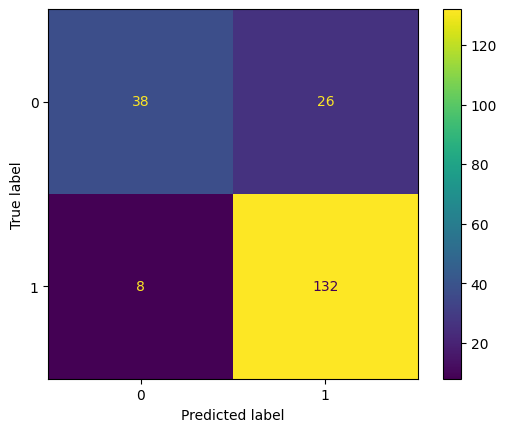

In [19]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

y_true = score['true']
y_pred = score['pred']

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()

print(classification_report(y_pred=y_pred, y_true=y_true))

In [23]:
tokenizer(texts, return_tensors="pt", padding=True)

NameError: name 'texts' is not defined

(tensor([[  101,  2002,  2056,  1996,  9440,  2121,  7903,  2063, 11345,  2449,
           2987,  1005,  1056,  4906,  1996,  2194,  1005,  1055,  2146,  1011,
           2744,  3930,  5656,  1012,   102,  1000,  1996,  9440,  2121,  7903,
           2063, 11345,  2449,  2515,  2025,  4906,  2256,  2146,  1011,  2744,
           3930,  5656,  1012,   102]], device='cuda:0'),
 tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
        device='cuda:0'),
 tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
        device='cuda:0'))

## Feature Attribution

### LIME
https://aclanthology.org/N16-3020.pdf

If the users do not trust a model or a prediction, they will not use it. In this paper, we describe a system that explains why a classifier made a prediction by identifying useful portions of the input.
We present, LIME, an algorithm that can explain the predictions of any classifier, by approximating it locally with an interpretable model.


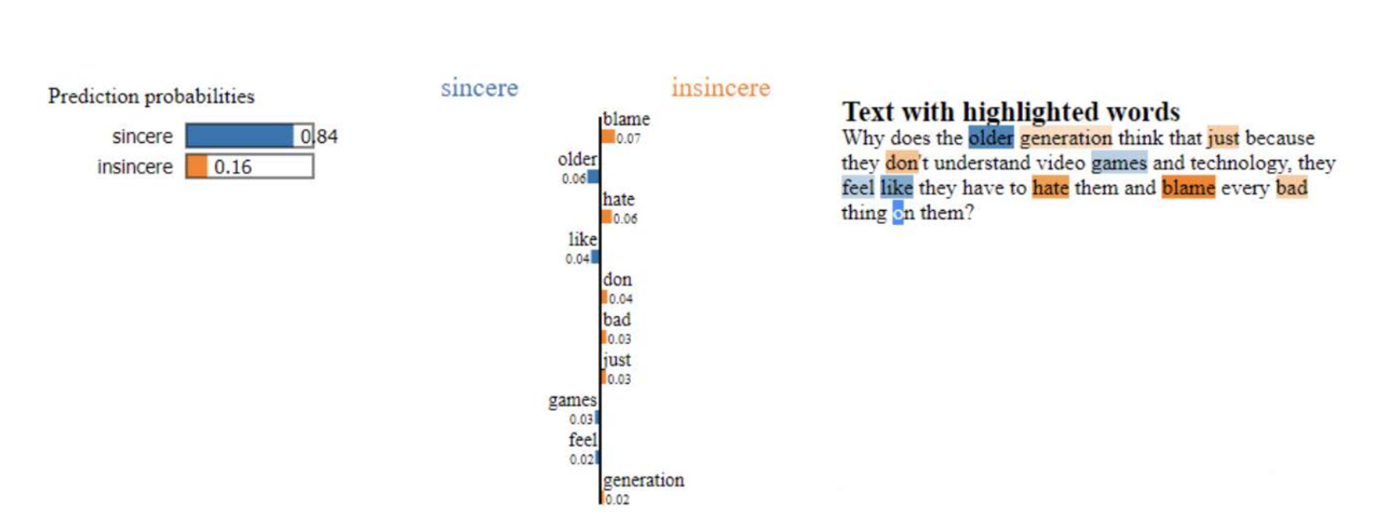

We present Local Interpretable Model-agnostic Explanations (LIME). The overall goal of LIME is to identify an interpretable model over the interpretable representation that is locally faithful to predictions of any classifier.

It is important to distinguish between features and interpretable data representations, the latter is a representation that is understandable to humans, regardless of the actual features used by the model:

Ex: A possible interpretable representation for text is a binary vector indicating the presence or absence of a word, even though the classifier may use more complex (and incomprehensible) features such as word embeddings.

We denote x ∈ R d as the original instance, and $x' ∈ {0, 1}^{d'}$ to denote a binary vector for its interpretable representation.

We define an explanation as a model g ∈ G, where G is the class of linear models such that: $g(z’) = w_g · z’$
Note that g acts over absence/presence of the interpretable components, i.e. we can readily present it to the user with visual artifacts.
We let Ω(g) be a measure of complexity (as opposed to interpretability) of the explanation g ∈ G.
For text classification, we set a limit K on the number of words included.

A model being explained is denoted by f.


**GOAL**: minize the "difference" $L$ betweeen f and g, while keeping the complexity $Ω(g)$ low.

$ξ(x) = argmin_{g∈G} L(f, g, Π_x) + Ω(g)$

So,
$L(f, g, Π_x)$ is a measure of how unfaithful g is in approximating f in the locality defined by $Π_x$.

$Π_x(z)$ as a proximity measure between an instance z to x, so as to define locality around x

We use the locally weighted square loss as $L$:

$L(f, g, Π_x) = \sum_{z,z’∈Z} Π_x(z)(f(z) − g(z’))^2 $

where we let $Π_x(z) = exp(−D(x, z)^2/σ^2 )$ be an exponential kernel on cosine distance $D$.

We approximate $L(f, g, Π_x)$ by drawing samples, weighted by $Π_x$


In [57]:
import numpy as np
import lime
import torch
import torch.nn.functional as F
from lime.lime_text import LimeTextExplainer

from transformers import AutoTokenizer, AutoModelForSequenceClassification

def predictor(texts):
    out = tokenizer(texts, return_tensors="pt", padding=True)
    input_ids, token_type_ids, attention_mask = out['input_ids'], out['token_type_ids'], out['attention_mask']
    #input_ids.to(device), token_type_ids.to(device), attention_mask.to(device)

    model.to('cpu')

    outputs = model(input_ids=input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)
    tensor_logits = outputs[0]
    probas = F.softmax(tensor_logits)
    probas = probas.detach().numpy()
    return probas

text = dataset['validation']['sentence'][0]
print("TRUE LABEL", dataset['validation']['label'][0])

explainer = LimeTextExplainer(class_names=[0,1])
exp = explainer.explain_instance(text, predictor, num_samples=20)
exp.show_in_notebook(text=text)

TRUE LABEL 1


<ipython-input-57-6e5cc8c1675c>:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probas = F.softmax(tensor_logits)
